# Imports

Guillaume Melis work

In [ ]:
import random as rd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import math
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier

# The Data

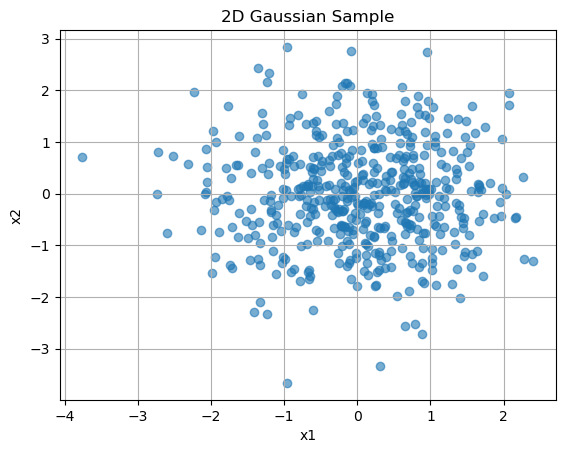

In [3]:
N = 500

xgauss1 = [rd.gauss(0, 1) for _ in range(N)]
xgauss2 = [rd.gauss(0, 1) for _ in range(N)]

plt.scatter(xgauss1, xgauss2, alpha=0.6)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('2D Gaussian Sample')
plt.grid(True)
plt.show()

## The Labeled data set

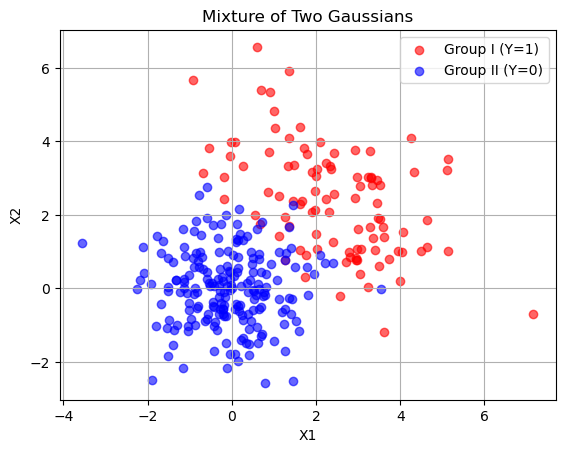

In [ ]:
# Group I parameters
n1 = 100
mu1 = np.array([2.5, 2.5])
sigma1 = np.array([[2, -0.8], 
                   [-0.8, 2]])

# Group II parameters
n2 = 200
mu2 = np.array([0, 0])
sigma2 = np.array([[1, 0],
                   [0, 1]])

# Simulate data
group1 = np.random.multivariate_normal(mu1, sigma1, n1)
group2 = np.random.multivariate_normal(mu2, sigma2, n2)

# Labels
Y1 = np.ones(n1)
Y2 = np.zeros(n2)

# Combine data
X = np.vstack((group1, group2))
Y = np.hstack((Y1, Y2))

# Plot
plt.scatter(group1[:,0], group1[:,1], color='red', alpha=0.6, label='Group I (Y=1)')
plt.scatter(group2[:,0], group2[:,1], color='blue', alpha=0.6, label='Group II (Y=0)')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Mixture of Two Gaussians')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
def stats(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    corr = np.corrcoef(data[:,0], data[:,1])[0,1]
    return mean, std, corr

mean1, std1, corr1 = stats(group1)
mean2, std2, corr2 = stats(group2)

print("Group I (Y=1):")
print("Mean:", mean1)
print("Std:", std1)
print("Correlation:", corr1)

print("\nGroup II (Y=0):")
print("Mean:", mean2)
print("Std:", std2)
print("Correlation:", corr2)

Group I (Y=1):
Mean: [2.37982874 2.38698999]
Std: [1.43815077 1.46190903]
Correlation: -0.4890288186842145

Group II (Y=0):
Mean: [-0.1012439   0.00760426]
Std: [1.0007258  1.02259059]
Correlation: -0.03375017762954688


## New Data Inputs without labels

In [6]:
x1, x2 = X[:,0], X[:,1]

#Eval data
x1_min, x1_max= min(x1), max(x1)
x2_min, x2_max= min(x2), max(x2)
Neval=15; h1= (x1_max-x1_min)/Neval; h2=(x2_max-x2_min)/Neval
x1Eval, x2Eval= np.meshgrid(np.arange(x1_min, x1_max, h1), np.arange(x2_min, x2_max, h2))
grid_points = np.c_[x1Eval.ravel(), x2Eval.ravel()]

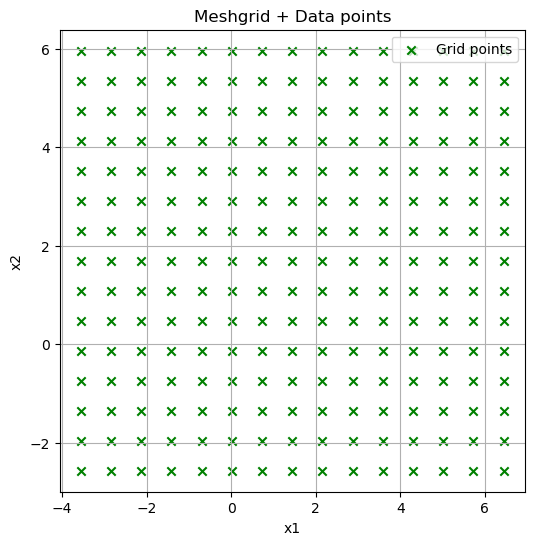

In [7]:
plt.figure(figsize=(6,6))
plt.scatter(x1Eval, x2Eval, color='green', marker='x', label='Grid points')
#plt.scatter(group1[:,0], group1[:,1], color='red', alpha=0.6, label='Group I (Y=1)')
#plt.scatter(group2[:,0], group2[:,1], color='blue', alpha=0.6, label='Group II (Y=0)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Meshgrid + Data points')
plt.legend()
plt.grid(True)
plt.show()

# A First Model of Machine Learning. The Naive Bayes model

In [8]:
classes = np.unique(Y)
print(classes)

priors = {}
for c in classes:
    priors[c] = np.mean(Y == c)

print("Priors:", priors)

[0. 1.]
Priors: {0.0: 0.6666666666666666, 1.0: 0.3333333333333333}


In [9]:
means = {}
stds = {}

for c in classes:
    X_c = X[Y == c]  # observations de la classe c
    means[c] = X_c.mean(axis=0)   # moyenne par dimension
    stds[c] = X_c.std(axis=0)     # écart-type par dimension

print("Means:", means)
print("Stds:", stds)

Means: {0.0: array([-0.1012439 ,  0.00760426]), 1.0: array([2.37982874, 2.38698999])}
Stds: {0.0: array([1.0007258 , 1.02259059]), 1.0: array([1.43815077, 1.46190903])}


In [10]:
def gaussian_likelihood_scalar(x, mean, std):
    likelihood = 1.0
    for i in range(len(x)):
        likelihood *= (1 / (np.sqrt(2 * np.pi) * std[i])) * np.exp(-0.5 * ((x[i]-mean[i])/std[i])**2)
    return likelihood


In [11]:
def predict_nb(X_new, classes, priors, means, stds):
    predictions = []
    for x in X_new:
        posteriors = []
        fposteriors = []
        for c in classes:
            likelihood = gaussian_likelihood_scalar(x, means[c], stds[c])
            posterior = likelihood * priors[c]
            posteriors.append(posterior)  
        predictions.append(classes[int(np.argmax(posteriors))])
    return np.array(predictions)

y_pred = predict_nb(X, classes, priors, means, stds)

In [12]:
accuracy = np.mean(y_pred == Y)
print("Training accuracy:", accuracy)

Training accuracy: 0.9566666666666667


## Evaluation of the model

### Number of errors, number of False Positive and False negative observations

In [13]:
print(y_pred.shape)
print(Y.shape)

(300,)
(300,)


In [14]:
n_errors = np.sum(y_pred != Y)
print("Total number of errors :", n_errors)

Total number of errors : 13


In [15]:
FN = np.sum((Y == 1) & (y_pred == 0))
print("False Negatives :", FN)

False Negatives : 6


In [16]:
FP = np.sum((Y == 0) & (y_pred == 1))
print("False Positives :", FP)

False Positives : 7


### Accuracy, Precision, recall and F1-Score

In [17]:
#from sklearn.metrics import confusion_matrix

#confusion_matrix(Y,y_pred)

In [18]:
TP = np.sum((Y == 0) & (y_pred == 0))
print("True Positive :",TP)

TN = np.sum((Y==1) & (y_pred == 1))
print("True Negative :",TN)

True Positive : 193
True Negative : 94


In [19]:
Accuracy = (TP+TN)/(TP+TN+FP+FN)
print('Accuracy score :', Accuracy)

Accuracy score : 0.9566666666666667


In [20]:
Recall = TP/(FN+TP)
print('Recall :', Recall)

Recall : 0.9698492462311558


In [21]:
precision = TP/(FP+TP)
print('Precision :', precision)

Precision : 0.965


In [22]:
F1_Score = 2*(precision*Recall)/(precision+Recall)
print("F1-Score for the Naive Bayes :", F1_Score)

F1-Score for the Naive Bayes : 0.9674185463659147


## Class Prediction for new inputs using the calibrated naive Bayes model

In [23]:
print(grid_points.shape)

(225, 2)


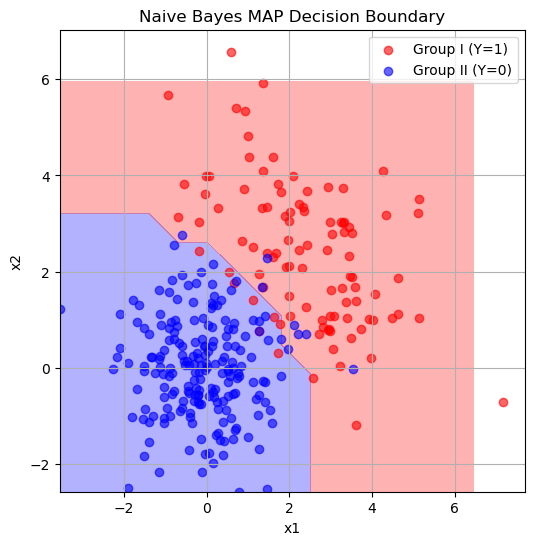

In [24]:
grid_pred = predict_nb(grid_points, classes, priors, means, stds)

grid_pred = grid_pred.reshape(x1Eval.shape)

plt.figure(figsize=(6,6))
plt.contourf(x1Eval, x2Eval, grid_pred, alpha=0.3, levels=[-0.5,0.5,1.5], colors=['blue','red'])
#plt.scatter(x1Eval, x2Eval, color='green', marker='x', label='Grid points')
plt.scatter(group1[:,0], group1[:,1], color='red', alpha=0.6, label='Group I (Y=1)')
plt.scatter(group2[:,0], group2[:,1], color='blue', alpha=0.6, label='Group II (Y=0)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Naive Bayes MAP Decision Boundary')
plt.legend()
plt.grid(True)
plt.show()

# The Sickit Learn Library

## Calibration and fit of the model

In [ ]:
gnb= GaussianNB()
gnbfit=gnb.fit(X, Y)
y_pred= gnbfit.predict(X)

## Model Parameter Analysis

In [26]:
gnb.class_count_

array([200., 100.])

In [27]:
gnb.class_prior_

array([0.66666667, 0.33333333])

In [28]:
gnb.classes_

array([0., 1.])

In [29]:
gnb.theta_

array([[-0.1012439 ,  0.00760426],
       [ 2.37982874,  2.38698999]])

In [30]:
gnb.var_

array([[1.00145212, 1.04569152],
       [2.06827764, 2.137178  ]])

We can see that there are no differences between our classes and the class_prior and what we had in our model before.   
For the parameter theta_ which is actually the mean, we can see that (Means: {0.0: array([ 0.06747598, -0.02630997]), 1.0: array([2.57598888, 2.57615554])}) it's actually exactly the same numbers.  
And finally for the variance we can easily understand that if we take the square root of gnb.var_ we obtain the same numbers.   


In [31]:
np.sqrt(gnb.var_)

array([[1.0007258 , 1.02259059],
       [1.43815077, 1.46190903]])

Emprirical Results -> Stds: {0.0: array([0.9996734 , 0.93872544]), 1.0: array([1.40830701, 1.21811722])}

## First Evaluation of the model on training Data

### Accuracy, precision, recall and F1-Score

In [ ]:
print(accuracy_score(Y,y_pred))
print(precision_score(Y,y_pred))
print(recall_score(Y,y_pred))
print(f1_score(Y,y_pred))

0.9566666666666667
0.9306930693069307
0.94
0.9353233830845771


Conclusion :  
We can see that we have the same accuracy as the first model but there are differences in the precision score, the recall and the f1-score. It could have mean that values for the confusion matrix (TP, TN, FP, FN) are different but actually it's not. So it could come from the way the library is doing the computation.  
What we observe is actually normal because as there exist analytics solution for the MLE for the Bayes model, the sickit learn library should tend to what we empirically estimated.

In [33]:
from sklearn.metrics import confusion_matrix

confusion_matrix(Y,y_pred)

array([[193,   7],
       [  6,  94]])

### AUC Indicator

In [ ]:
y_score = gnb.predict_proba(X)[:, 1]
fpr, tpr, thresholds = roc_curve(Y, y_score)
auc(fpr,tpr)

0.99355

### The ROC Curve

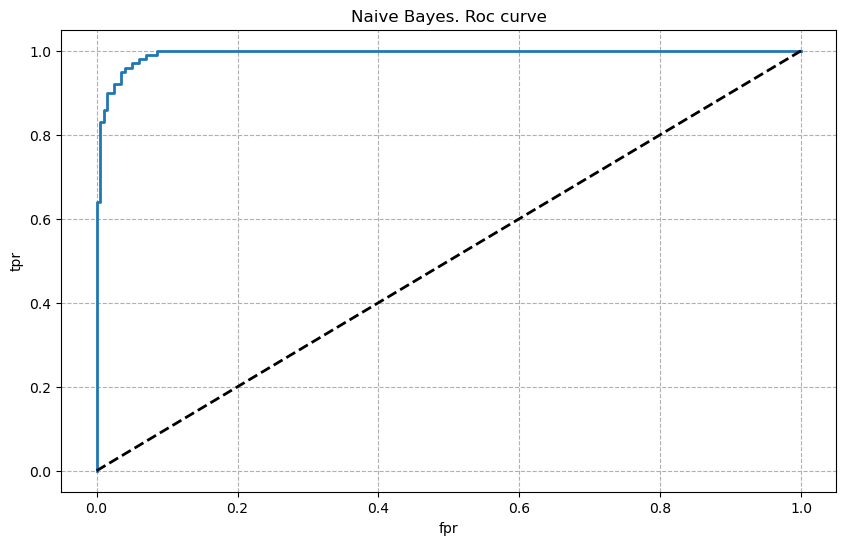

In [35]:
y_proba= gnbfit.predict_proba(X)[:,1];
fpr, tpr, thresholds= roc_curve(Y, y_proba);
figure= plt.figure(figsize=(10,6));
plt.plot(fpr,tpr, linewidth= 2);
plt.title('Naive Bayes. Roc curve')
plt.xlabel('fpr');plt.ylabel('tpr')
plt.plot(tpr,tpr,"k--", linewidth= 2)
plt.grid(linestyle= 'dashed') 
plt.show()

## Evaluation of the predictive power

### Cross Validation

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(X, Y, test_size=1/3, random_state=0)
gnb= GaussianNB()
gnbfit=gnb.fit(X_train, y_train)
y_pred= gnbfit.predict(X_test)
E_test=(y_test != y_pred).sum()/len(y_test)
print("Error on the test data set",E_test)

Error on the test data set 0.05


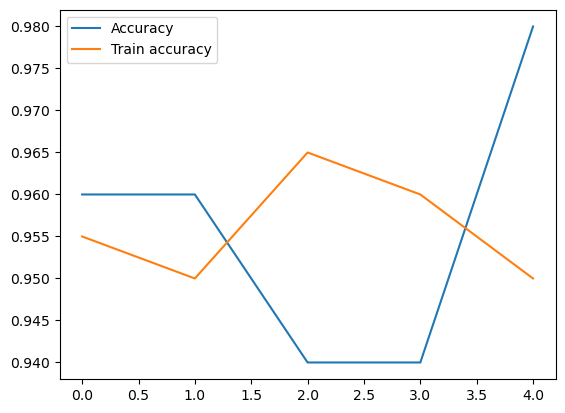

In [37]:
accuracy = []
accuracy_train = []
error = []
for i in range(5):
    X_train, X_test, y_train, y_test= train_test_split(X, Y, test_size=1/3, stratify=Y, random_state=i)
    gnb= GaussianNB()
    gnbfit=gnb.fit(X_train, y_train)
    y_pred= gnbfit.predict(X_test)
    E_test=(y_test != y_pred).sum()/len(y_test)
    error += [E_test]
    accuracy += [accuracy_score(y_test,y_pred)]
    accuracy_train += [accuracy_score(y_train,gnbfit.predict(X_train))]


plt.plot(accuracy, label="Accuracy")
plt.plot(accuracy_train, label='Train accuracy')
plt.legend()
plt.show()


We clearly see that the accuracy is decreasing function of K. 

### K-Fold Methdology

In [ ]:
kf = KFold(n_splits=5)

kf.get_n_splits(X)

scoring = {
    'accuracy': 'accuracy',
    'auc': 'roc_auc',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall'
}

cv_results = cross_validate(gnb, X, Y, cv=kf, scoring=scoring, return_train_score=True)

/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/anaconda3/envs/ml_env/lib/python3.10/site-pa

In [39]:
cv_results

{'fit_time': array([0.00098014, 0.00027394, 0.00023508, 0.00022507, 0.00021124]),
 'score_time': array([0.01005697, 0.00629091, 0.00302172, 0.002141  , 0.00214291]),
 'test_accuracy': array([0.86666667, 0.95      , 0.93333333, 0.96666667, 0.91666667]),
 'train_accuracy': array([0.97083333, 0.95      , 0.95833333, 0.95      , 0.9625    ]),
 'test_auc': array([    nan, 0.99875,     nan,     nan,     nan]),
 'train_auc': array([0.994625  , 0.99231481, 0.99321429, 0.99271429, 0.99542857]),
 'test_f1': array([0.92857143, 0.96103896, 0.        , 0.        , 0.        ]),
 'train_f1': array([0.91139241, 0.9       , 0.95098039, 0.94174757, 0.95566502]),
 'test_precision': array([1., 1., 0., 0., 0.]),
 'train_precision': array([0.92307692, 0.9       , 0.93269231, 0.91509434, 0.94174757]),
 'test_recall': array([0.86666667, 0.925     , 0.        , 0.        , 0.        ]),
 'train_recall': array([0.9 , 0.9 , 0.97, 0.97, 0.97])}

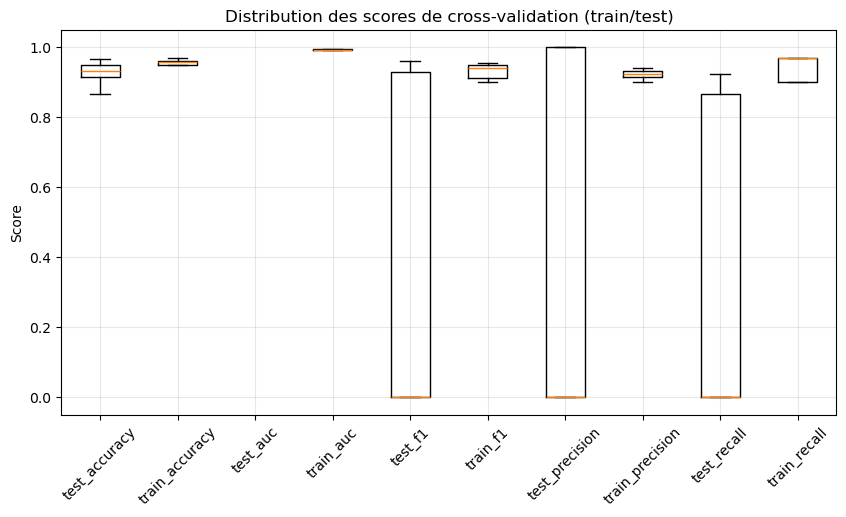

In [40]:
keys = [key for key in cv_results.keys() if key.startswith('test') or key.startswith('train')]
values = [cv_results[key] for key in keys]

plt.figure(figsize=(10, 5))
plt.boxplot(values)
plt.xticks(range(1, len(keys) + 1), keys, rotation=45)
plt.title("Distribution des scores de cross-validation (train/test)")
plt.ylabel("Score")
plt.grid(True, alpha=0.3)
plt.show()

We can clearly see, given this metrics is that the Naive Bayes has a good ability to fit the date while training but performing well on the data while they are new can bee difficult (regading teh results for teh f-1 score, the precision and the recall). It's funny to see that the accuracy is good for train and for test. 

# Classification learning machines

## Linear Discriminant Analysis

In [ ]:
lda= LinearDiscriminantAnalysis(n_components=1, store_covariance=True)

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

lda.fit(X_train,y_train)
y_pred = lda.predict(X_test)

In [42]:
print("Class labels:", lda.classes_)
print("Class means:\n", lda.means_)
if hasattr(lda, "covariance_"):
    print("Shared covariance matrix:\n", lda.covariance_)
else:
    print("Covariance matrix is not stored (set store_covariance=True if you need it).")


Class labels: [0. 1.]
Class means:
 [[-0.10045273 -0.01560524]
 [ 2.34929971  2.24757859]]
Shared covariance matrix:
 [[ 1.20703845 -0.35778123]
 [-0.35778123  1.39252846]]


The centroids are very far apart in feature space, which explains why LDA separates the classes well.  
The variables are slightly correlated (off-diagonal = -0.285), but the covariance is not too high → LDA can construct an effective linear boundary.

In [43]:
y_pred_train = lda.predict(X_train)

acc = accuracy_score(y_train, y_pred_train)
prec = precision_score(y_train, y_pred_train, average='weighted')
rec = recall_score(y_train, y_pred_train, average='weighted')
f1 = f1_score(y_train, y_pred_train, average='weighted')

print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-score: {f1:.3f}")

print("\nClassification Report:\n", classification_report(y_train, y_pred_train))

Accuracy: 0.958
Precision: 0.958
Recall: 0.958
F1-score: 0.958

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       162
         1.0       0.95      0.92      0.94        78

    accuracy                           0.96       240
   macro avg       0.96      0.95      0.95       240
weighted avg       0.96      0.96      0.96       240



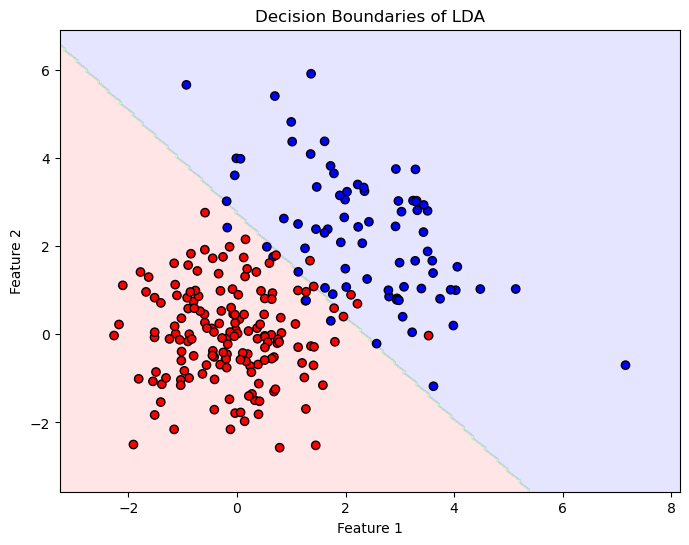

In [ ]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF']))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolor='k', cmap=ListedColormap(['#FF0000', '#00FF00', '#0000FF']))
plt.title("Decision Boundaries of LDA")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

## Quadratic Discriminant Analysis

In [ ]:
qda= QuadraticDiscriminantAnalysis(store_covariance=True)

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

qda.fit(X_train,y_train)

,priors,None
,reg_param,0.0
,store_covariance,True
,tol,0.0001


In [46]:
print("Class labels:", qda.classes_)
print("Class means:\n", qda.means_)
if hasattr(qda, "covariance_"):
    print("Shared covariance matrix:\n", qda.covariance_)
else:
    print("Covariance matrix is not stored (set store_covariance=True if you need it).")

Class labels: [0. 1.]
Class means:
 [[-0.10045273 -0.01560524]
 [ 2.34929971  2.24757859]]
Shared covariance matrix:
 [array([[ 0.94187967, -0.02662272],
       [-0.02662272,  1.08942344]]), array([[ 1.79281299, -1.05949659],
       [-1.05949659,  2.06246307]])]


Les centroides sont identiques à LDA → les centres des distributions n’ont pas changé.  
Contrairement à LDA, chaque classe a sa propre matrice de covariance → QDA va tracer une frontière quadratique pour séparer les classes.  

In [47]:
y_pred_train = qda.predict(X_train)

acc = accuracy_score(y_train, y_pred_train)
prec = precision_score(y_train, y_pred_train, average='weighted')
rec = recall_score(y_train, y_pred_train, average='weighted')
f1 = f1_score(y_train, y_pred_train, average='weighted')

print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-score: {f1:.3f}")

print("\nClassification Report:\n", classification_report(y_train, y_pred_train))

Accuracy: 0.954
Precision: 0.954
Recall: 0.954
F1-score: 0.954

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       162
         1.0       0.95      0.91      0.93        78

    accuracy                           0.95       240
   macro avg       0.95      0.94      0.95       240
weighted avg       0.95      0.95      0.95       240



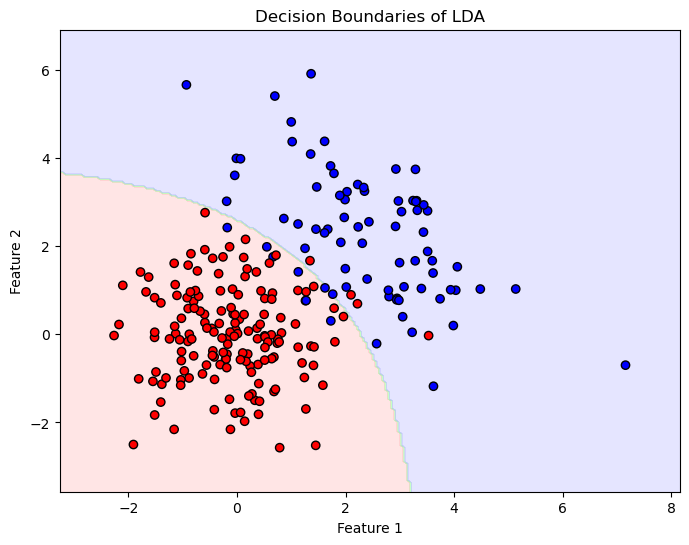

In [ ]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

Z = qda.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF']))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolor='k', cmap=ListedColormap(['#FF0000', '#00FF00', '#0000FF']))
plt.title("Decision Boundaries of LDA")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

## Logistic Regresssion

In [ ]:
logreg= linear_model.LogisticRegression(C=1e5)

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

logreg.fit(X_train,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,100000.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [50]:
print("Coefficients:", logreg.coef_)
print("Intercept:", logreg.intercept_)
print("Classes:", logreg.classes_)
print("Nombre d'itérations:", logreg.n_iter_)

Coefficients: [[2.81168021 2.84830553]]
Intercept: [-7.25271255]
Classes: [0. 1.]
Nombre d'itérations: [13]


L’analyse comparative des modèles LDA, QDA et régression logistique révèle une séparation claire des classes, avec des performances élevées en précision et rappel. LDA et la régression logistique produisent des frontières linéaires proches en raison de la similarité des covariances, tandis que QDA, en tenant compte des covariances propres à chaque classe, offre une flexibilité accrue pour capturer les différences structurelles. Ces résultats confirment que, pour des classes bien séparées et des distributions quasi-gaussiennes, les modèles paramétriques linéaires restent robustes et interprétables.

In [51]:
y_pred_train = logreg.predict(X_train)

acc = accuracy_score(y_train, y_pred_train)
prec = precision_score(y_train, y_pred_train, average='weighted')
rec = recall_score(y_train, y_pred_train, average='weighted')
f1 = f1_score(y_train, y_pred_train, average='weighted')

print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-score: {f1:.3f}")

print("\nClassification Report:\n", classification_report(y_train, y_pred_train))

Accuracy: 0.950
Precision: 0.950
Recall: 0.950
F1-score: 0.950

Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.98      0.96       162
         1.0       0.95      0.90      0.92        78

    accuracy                           0.95       240
   macro avg       0.95      0.94      0.94       240
weighted avg       0.95      0.95      0.95       240



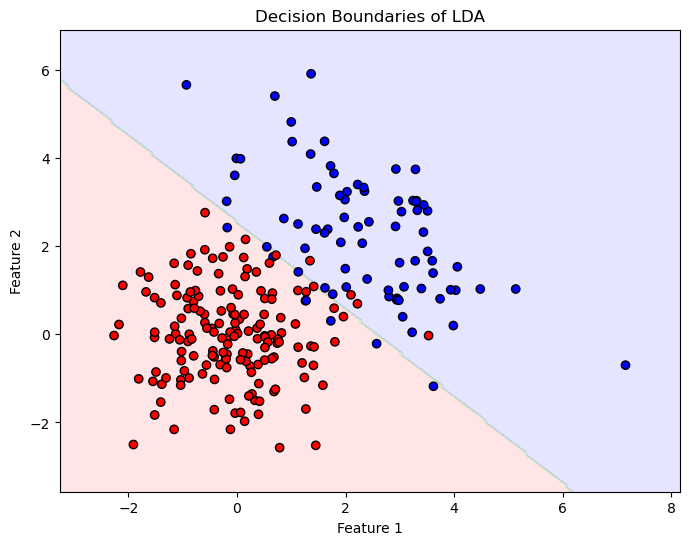

In [ ]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF']))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolor='k', cmap=ListedColormap(['#FF0000', '#00FF00', '#0000FF']))
plt.title("Decision Boundaries of LDA")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

## KNN

In [ ]:
knn= KNeighborsClassifier(n_neighbors=5)

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

knn.fit(X_train,y_train)
y_pred = knn.predict(X_train)

As KNN is a lazy algorithm there is no parameters to display here. 

In [59]:
print("Accuracy:", accuracy_score(y_train, y_pred))
print("Precision:", precision_score(y_train, y_pred, average='weighted'))
print("Recall:", recall_score(y_train, y_pred, average='weighted'))
print("F1-score:", f1_score(y_train, y_pred, average='weighted'))

Accuracy: 0.9708333333333333
Precision: 0.9712964481994916
Recall: 0.9708333333333333
F1-score: 0.9705720727067776


In [60]:
print("\nClassification Report:\n", classification_report(y_train, y_pred))


Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       162
         1.0       0.99      0.92      0.95        78

    accuracy                           0.97       240
   macro avg       0.98      0.96      0.97       240
weighted avg       0.97      0.97      0.97       240



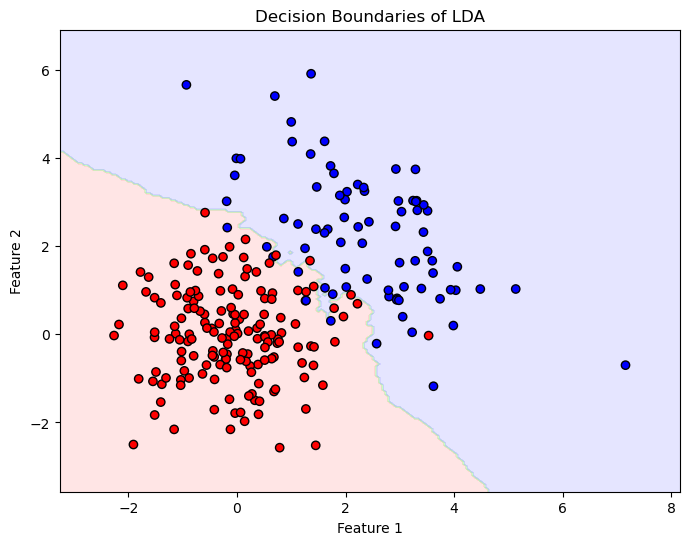

In [61]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF']))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolor='k', cmap=ListedColormap(['#FF0000', '#00FF00', '#0000FF']))
plt.title("Decision Boundaries of LDA")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [62]:
print(knn.score(X_train,y_train))
print(knn.score(X_test,y_test))

0.9708333333333333
0.95


The distance by default for this algorithm is the Minkowsky with p=2 which mean the Euclidian distance.   
As we us the euclidian distance, we need to standardise the data because they're not scaled in the algorithm and a very far point could influence the euclidian distance. 

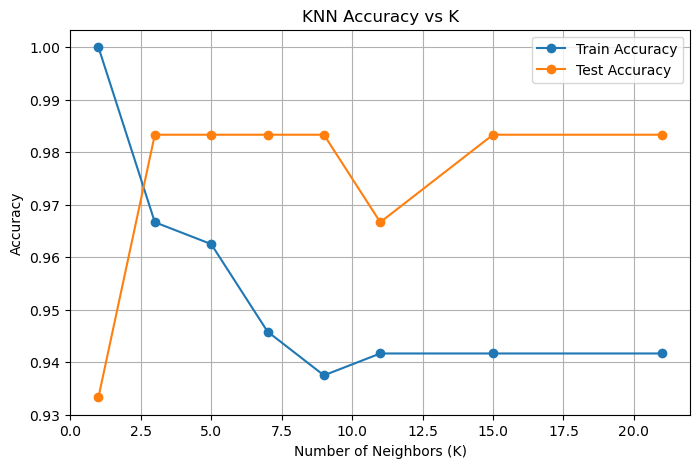

Best K: 17
Best CV Accuracy: 0.9416666666666667


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


k_values = [1, 3, 5, 7, 9, 11, 15, 21]
train_scores = []
test_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    
    train_scores.append(knn.score(X_train_scaled, y_train))
    test_scores.append(knn.score(X_test_scaled, y_test))

plt.figure(figsize=(8,5))
plt.plot(k_values, train_scores, label='Train Accuracy', marker='o')
plt.plot(k_values, test_scores, label='Test Accuracy', marker='o')
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy vs K")
plt.legend()
plt.grid(True)
plt.show()

param_grid = {'n_neighbors': range(1, 21)}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_scaled, y_train)

print("Best K:", grid.best_params_['n_neighbors'])
print("Best CV Accuracy:", grid.best_score_)

We see that different values of K affect directly the accuracy of the algorithm. To chose the best K parameter, we should perform a GridSearch cross validation. 
It's fun to see that actually the accuracy is not way better than while not performing the Cross Validation procedure and performing a scaling of the datas. 

# How to chose the appropriate Classifier

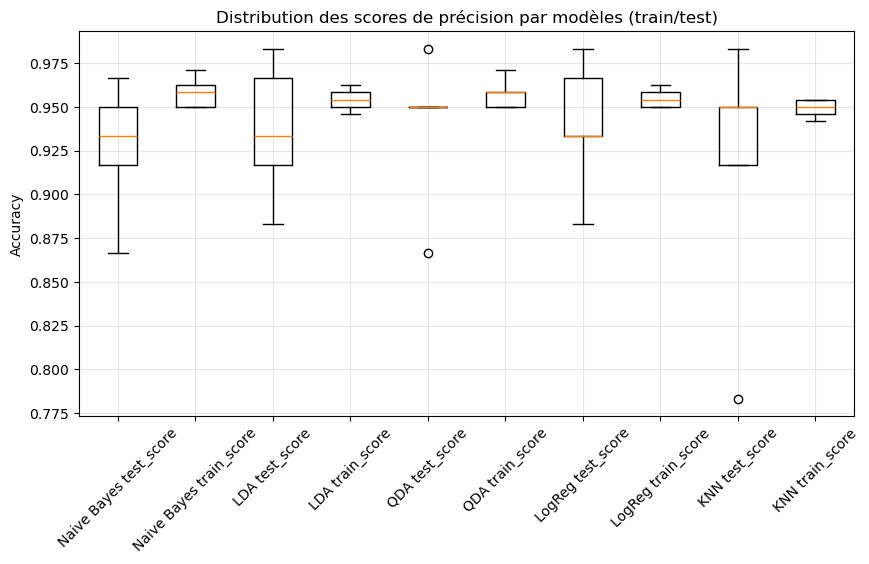

In [76]:
#Comparing the accuracy on a same plot to compare the models. 

models = [(gnb,'Naive Bayes'), (lda,'LDA'), (qda,'QDA'), (logreg,'LogReg'), (knn,"KNN")]

kf = KFold(n_splits=5)

kf.get_n_splits(X)

keys = []
key_to_display = []
values = []


for model, model_name in models : 
    model.fit(X_train,y_train)
    cv_results = cross_validate(model, X, Y, cv=kf, scoring="accuracy", return_train_score=True)
    
    for key in cv_results.keys():
        if key.startswith('test') or key.startswith('train'):
            key_to_display.append(f"{model_name} {key}")
            values.append(cv_results[key])

plt.figure(figsize=(10, 5))
plt.boxplot(values)
plt.xticks(range(1, len(key_to_display) + 1), key_to_display, rotation=45)
plt.title("Distribution des scores de précision par modèles (train/test)")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)
plt.show()
    
